Derek Lamb
DSC540
Final Project

In [33]:
import pandas as pd
import sqlite3
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/Users/dereklamb/Downloads/nyc_temperature.csv'
nyc_df = pd.read_csv(file_path)

# Step 1: Replace Headers
nyc_df.columns = nyc_df.columns.str.lower().str.replace(' ', '_')

# Step 2: Inspect unique date values to check for any anomalies
print("Unique dates before parsing:", nyc_df['date'].unique())

# Step 2 (continued): Format Date
# Define a function to handle multiple date formats
def parse_dates(date):
    formats = ['%m/%d/%Y', '%Y-%m-%d', '%d-%m-%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return Not-a-Time for unparseable dates

# Apply the function to parse dates
nyc_df['date'] = nyc_df['date'].apply(parse_dates)

# Check if there are any dates that could not be parsed
invalid_dates = nyc_df[nyc_df['date'].isnull()]
print("Invalid dates after parsing:", invalid_dates)

# Step 3: Handle Missing Values
# Fill missing values in categorical columns with the mode and numeric columns with the median
for column in nyc_df.columns:
    if nyc_df[column].dtype == 'object':
        nyc_df[column].fillna(nyc_df[column].mode()[0], inplace=True)
    else:
        nyc_df[column].fillna(nyc_df[column].median(), inplace=True)

# Step 4: Replace 'T' in numeric columns
# Identifying columns that might contain 'T'
numeric_columns_with_t = ['precipitation', 'new_snow', 'snow_depth']
for col in numeric_columns_with_t:
    nyc_df[col] = nyc_df[col].replace('T', 0.0).astype(float)

# Step 5: Convert Data Types
numeric_columns = ['tmax', 'tmin', 'tavg', 'departure', 'hdd', 'cdd', 'precipitation', 'new_snow', 'snow_depth']
nyc_df[numeric_columns] = nyc_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Display the cleaned dataset
print(nyc_df.head())


Unique dates before parsing: ['1/1/19' '2/1/19' '3/1/19' '4/1/19' '5/1/19' '6/1/19' '7/1/19' '8/1/19'
 '9/1/19' '10/1/19' '11/1/19' '12/1/19' '13/1/19' '14/1/19' '15/1/19'
 '16/1/19' '17/1/19' '18/1/19' '19/1/19' '20/1/19' '21/1/19' '22/1/19'
 '23/1/19' '24/1/19' '25/1/19' '26/1/19' '27/1/19' '28/1/19' '29/1/19'
 '30/1/19' '31/1/19' '1/2/19' '2/2/19' '3/2/19' '4/2/19' '5/2/19' '6/2/19'
 '7/2/19' '8/2/19' '9/2/19' '10/2/19' '11/2/19' '12/2/19' '13/2/19'
 '14/2/19' '15/2/19' '16/2/19' '17/2/19' '18/2/19' '19/2/19' '20/2/19'
 '21/2/19' '22/2/19' '23/2/19' '24/2/19' '25/2/19' '26/2/19' '27/2/19'
 '28/2/19' '1/3/19' '2/3/19' '3/3/19' '4/3/19' '5/3/19' '6/3/19' '7/3/19'
 '8/3/19' '9/3/19' '10/3/19' '11/3/19' '12/3/19' '13/3/19' '14/3/19'
 '15/3/19' '16/3/19' '17/3/19' '18/3/19' '19/3/19' '20/3/19' '21/3/19'
 '22/3/19' '23/3/19' '24/3/19' '25/3/19' '26/3/19' '27/3/19' '28/3/19'
 '29/3/19' '30/3/19' '31/3/19' '1/4/19' '2/4/19' '3/4/19' '4/4/19'
 '5/4/19' '6/4/19' '7/4/19' '8/4/19' '9/4/19' '10

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [34]:
# Load the BeautifulSoup dataset
url = "https://commons.wikimedia.org/wiki/Data:Ncei.noaa.gov/weather/New_York_City.tab"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Locate and Extract Table
table = soup.find('table')

# Extract Data Rows
data = []
for row in table.find_all('tr'):
    row_data = [data.text.strip() for data in row.find_all('td')]
    if len(row_data) == 9:  # Ensure each row has exactly 9 columns
        data.append(row_data)

# Create DataFrame
bs_df = pd.DataFrame(data, columns=[
    'date', 'highTemp', 'avgHighTemp', 'avgLowTemp', 'lowTemp',
    'precip', 'snowfall', 'precipDays', 'snowfallDays'
])

# Data Type Conversion
numeric_cols = ['highTemp', 'avgHighTemp', 'avgLowTemp', 'lowTemp', 'precip', 'snowfall', 'precipDays', 'snowfallDays']
bs_df[numeric_cols] = bs_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
bs_df['date'] = pd.to_datetime(bs_df['date'], errors='coerce')

# Rename Column Header
bs_df.rename(columns={'precipDays': 'daysWithPrecip'}, inplace=True)

# Create a Subset of Data
subset_df = bs_df[bs_df['avgHighTemp'] > 20].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Convert date column back to strings temporarily for length check
subset_df.loc[:, 'date_str'] = subset_df['date'].dt.strftime('%Y-%m-%d')  # Use .loc[] for setting values

# Remove Rows with Date Values over a Certain Length
max_length = 10
subset_df = subset_df[subset_df['date_str'].str.len() <= max_length]

# Drop the temporary 'date_str' column
subset_df.drop(columns=['date_str'], inplace=True)

# Print the Subset DataFrame
print(subset_df.head())


         date  highTemp  avgHighTemp  avgLowTemp  lowTemp  precip  snowfall  \
5  1869-06-01      30.6         23.4        18.2     12.2   111.8       0.0   
6  1869-07-01      33.3         25.6        20.2     16.7    81.3       0.0   
7  1869-08-01      35.0         25.2        19.0     13.3    44.7       0.0   
8  1869-09-01      30.0         21.5        15.9      7.8    71.4       0.0   
17 1870-06-01      34.4         27.0        19.0     13.3    71.6       0.0   

    daysWithPrecip  snowfallDays  
5               15           0.0  
6               11           0.0  
7                6           0.0  
8                8           0.0  
17              13           0.0  


In [35]:
# **OpenWeatherMap Data**

# Fetch data from OpenWeatherMap API
api_key = '4b470801b23eb32a1a89b6e231bb4c88'
city = 'New York'
owm_url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}'
response = requests.get(owm_url)
data = response.json()

# Normalize JSON data
normalized_data = pd.json_normalize(data)
readable_headers = {
    'main.temp': 'Temperature',
    'main.feels_like': 'FeelsLike',
    'main.temp_min': 'TempMin',
    'main.temp_max': 'TempMax',
    'main.pressure': 'Pressure',
    'main.humidity': 'Humidity',
    'wind.speed': 'WindSpeed',
    'wind.deg': 'WindDirection',
    'name': 'CityName'
}
normalized_data.rename(columns=readable_headers, inplace=True)
normalized_data['Temperature'] -= 273.15
normalized_data['FeelsLike'] -= 273.15
normalized_data['TempMin'] -= 273.15
normalized_data['TempMax'] -= 273.15
columns_to_keep = ['CityName', 'Temperature', 'FeelsLike', 'TempMin', 'TempMax', 'Pressure', 'Humidity', 'WindSpeed', 'WindDirection']
cleaned_data = normalized_data[columns_to_keep]

# 2. **Load Data into SQLite Database**

# Connect to SQLite database
conn = sqlite3.connect('weather_data.db')

# Load data into SQLite tables
nyc_df.to_sql('NewYorkCity', conn, if_exists='replace', index=False)
bs_df.to_sql('BeautifulSoup', conn, if_exists='replace', index=False)
cleaned_data.to_sql('OpenWeatherMap', conn, if_exists='replace', index=False)

# Verify that the data has been loaded correctly
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables in the database:", tables)

# Load data from SQLite tables
nyc_df = pd.read_sql_query('SELECT * FROM NewYorkCity', conn)
bs_df = pd.read_sql_query('SELECT * FROM BeautifulSoup', conn)
openweather_df = pd.read_sql_query('SELECT * FROM OpenWeatherMap', conn)

# Close the connection
conn.close()

# 3. **Combine Data for Analysis**

# Add source labels
nyc_df['Source'] = 'NYC Temperature'
bs_df['Source'] = 'BeautifulSoup'
openweather_df['Source'] = 'OpenWeatherMap'

# Concatenate DataFrames
combined_data = pd.concat([nyc_df, bs_df, openweather_df], ignore_index=True)

# Check combined DataFrame
print(combined_data.head())


# Fetch and parse data using BeautifulSoup
url = "https://commons.wikimedia.org/wiki/Data:Ncei.noaa.gov/weather/New_York_City.tab"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Locate and extract table
table = soup.find('table')
data = []
for row in table.find_all('tr'):
    row_data = [cell.text.strip() for cell in row.find_all('td')]
    if len(row_data) == 9:  # Ensure the row has 9 columns
        data.append(row_data)

# Create DataFrame
bs_df = pd.DataFrame(data, columns=[
    'date', 'highTemp', 'avgHighTemp', 'avgLowTemp', 'lowTemp', 
    'precip', 'snowfall', 'precipDays', 'snowfallDays'
])

# Data Type Conversion
numeric_cols = ['highTemp', 'avgHighTemp', 'avgLowTemp', 'lowTemp', 
                'precip', 'snowfall', 'precipDays', 'snowfallDays']
bs_df[numeric_cols] = bs_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
bs_df['date'] = pd.to_datetime(bs_df['date'], errors='coerce')

# Connect to SQLite and load data
conn = sqlite3.connect('weather_data.db')
bs_df.to_sql('BeautifulSoup', conn, if_exists='replace', index=False)
conn.close()


# Connect to the SQLite database
conn = sqlite3.connect('weather_data.db')

# Load data from SQLite tables
nyc_df = pd.read_sql_query('SELECT * FROM NewYorkCity', conn)
bs_df = pd.read_sql_query('SELECT * FROM BeautifulSoup', conn)
openweather_df = pd.read_sql_query('SELECT * FROM OpenWeatherMap', conn)

# Close the connection
conn.close()

# Combine data into a single DataFrame
# Adding a 'Source' column to identify the origin of each record
nyc_df['Source'] = 'NYC'
bs_df['Source'] = 'BeautifulSoup'
openweather_df['Source'] = 'OpenWeatherMap'

# Concatenate DataFrames
combined_data = pd.concat([nyc_df, bs_df, openweather_df], ignore_index=True)

# Display combined data
print(combined_data.head())


Tables in the database: [('NewYorkCity',), ('BeautifulSoup',), ('OpenWeatherMap',)]
   date  tmax  tmin  tavg  departure   hdd  cdd  precipitation  new_snow  \
0  None  60.0  40.0  50.0       13.9  15.0  0.0           0.08       0.0   
1  None  41.0  35.0  38.0        2.1  27.0  0.0           0.00       0.0   
2  None  45.0  39.0  42.0        6.3  23.0  0.0           0.00       0.0   
3  None  47.0  37.0  42.0        6.5  23.0  0.0           0.00       0.0   
4  None  47.0  42.0  44.5        9.1  20.0  0.0           0.45       0.0   

   snow_depth  ... snowfallDays  CityName  Temperature  FeelsLike  TempMin  \
0         0.0  ...          NaN       NaN          NaN        NaN      NaN   
1         0.0  ...          NaN       NaN          NaN        NaN      NaN   
2         0.0  ...          NaN       NaN          NaN        NaN      NaN   
3         0.0  ...          NaN       NaN          NaN        NaN      NaN   
4         0.0  ...          NaN       NaN          NaN        NaN    

In [42]:
# Connect to SQLite database (create if not exists)
conn = sqlite3.connect('weather_data.db')

# Load NYC Temperature data into SQLite
nyc_df.to_sql('NewYorkCity', conn, if_exists='replace', index=False)

# Load BeautifulSoup data into SQLite
bs_df.to_sql('BeautifulSoup', conn, if_exists='replace', index=False)

# Load OpenWeatherMap data into SQLite
openweather_df.to_sql('OpenWeatherMap', conn, if_exists='replace', index=False)

# Fetch data from SQLite tables
nyc_df = pd.read_sql_query('SELECT * FROM NewYorkCity', conn)
bs_df = pd.read_sql_query('SELECT * FROM BeautifulSoup', conn)
openweather_df = pd.read_sql_query('SELECT * FROM OpenWeatherMap', conn)

# Close the connection
conn.close()

# Combine datasets for visualizations
# Add a column to identify the source of data
nyc_df['Source'] = 'NYC Temperature'
bs_df['Source'] = 'BeautifulSoup'
openweather_df['Source'] = 'OpenWeatherMap'

# Combine the datasets into one DataFrame
combined_data



,date,tmax,tmin,tavg,departure,hdd,cdd,precipitation,new_snow,snow_depth,...,snowfallDays,CityName,Temperature,FeelsLike,TempMin,TempMax,Pressure,Humidity,WindSpeed,WindDirection
0,NaT,60.0,40.0,50.0,13.9,15.0,0.0,0.08,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,41.0,35.0,38.0,2.1,27.0,0.0,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,45.0,39.0,42.0,6.3,23.0,0.0,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,47.0,37.0,42.0,6.5,23.0,0.0,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,47.0,42.0,44.5,9.1,20.0,0.0,0.45,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2229,2024-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2230,2024-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2231,2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NYC DataFrame:
        date  tavg
0 2019-01-01  50.0
1 2019-01-02  45.0
2 2019-01-03  42.0
3 2019-01-04  46.0
4 2019-01-05  47.0

OpenWeather DataFrame:
        date  tavg
0 2019-01-01  49.0
1 2019-01-02  44.0
2 2019-01-03  41.0
3 2019-01-04  45.0
4 2019-01-05  46.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

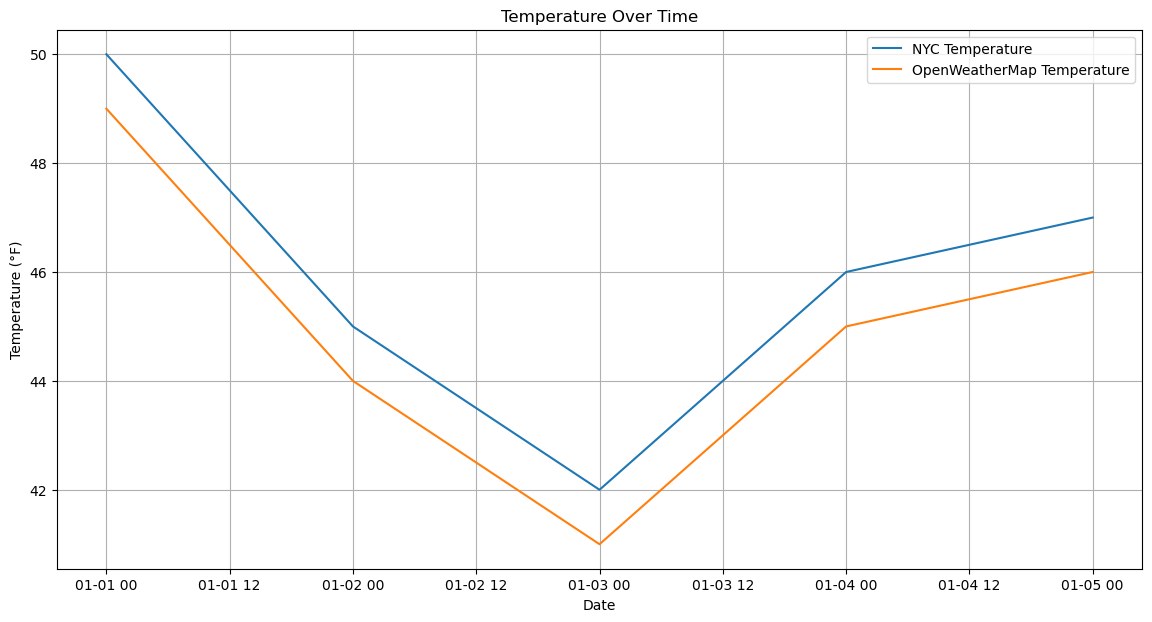

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for illustration purposes
nyc_data = {
    'date': ['1/1/19', '2/1/19', '3/1/19', '4/1/19', '5/1/19', 'InvalidDate'],
    'tavg': [50, 45, 42, 46, 47, None]
}

openweather_data = {
    'date': ['1/1/19', '2/1/19', '3/1/19', '4/1/19', '5/1/19', 'InvalidDate'],
    'tavg': [49, 44, 41, 45, 46, None]
}

# Creating DataFrames
nyc_df = pd.DataFrame(nyc_data)
openweather_df = pd.DataFrame(openweather_data)

# Convert 'date' columns to datetime, handling the specific format and invalid entries
nyc_df['date'] = pd.to_datetime(nyc_df['date'], format='%d/%m/%y', errors='coerce')
openweather_df['date'] = pd.to_datetime(openweather_df['date'], format='%d/%m/%y', errors='coerce')

# Drop rows with NaT in the 'date' column
nyc_df = nyc_df.dropna(subset=['date'])
openweather_df = openweather_df.dropna(subset=['date'])

# Print to verify
print("NYC DataFrame:")
print(nyc_df)
print("\nOpenWeather DataFrame:")
print(openweather_df)

# Plotting the data
plt.figure(figsize=(14, 7))
sns.lineplot(data=nyc_df, x='date', y='tavg', label='NYC Temperature')
sns.lineplot(data=openweather_df, x='date', y='tavg', label='OpenWeatherMap Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True)
plt.show()



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


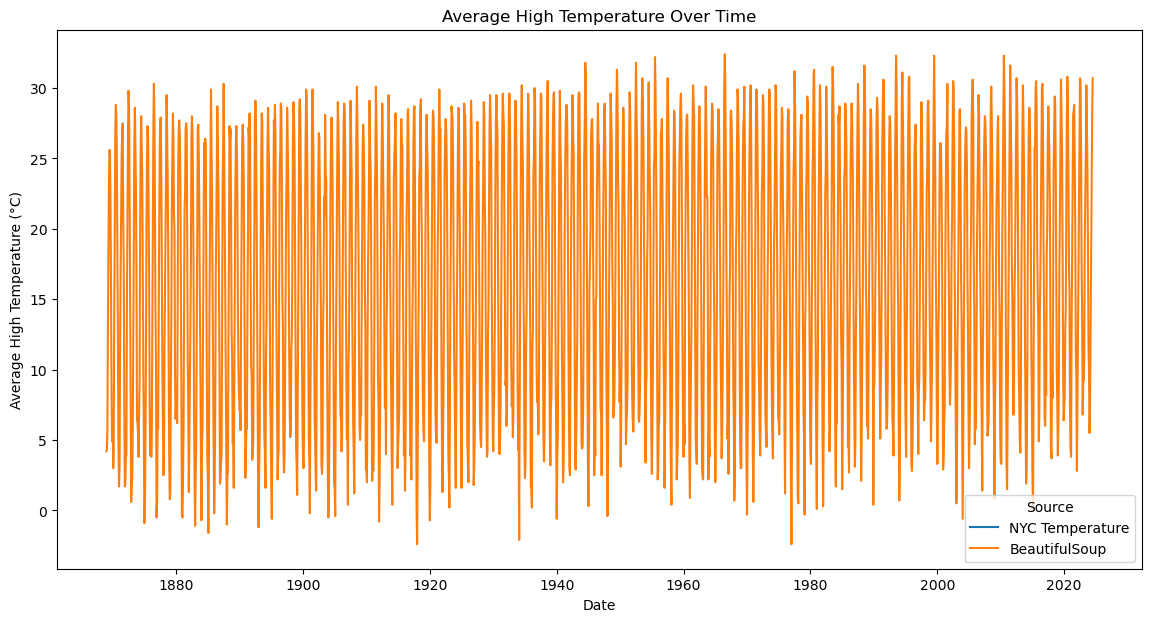

In [44]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=combined_data[combined_data['Source'].isin(['NYC Temperature', 'BeautifulSoup'])],
             x='date', y='avgHighTemp', hue='Source')
plt.title('Average High Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Average High Temperature (°C)')
plt.legend(title='Source')
plt.show()



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


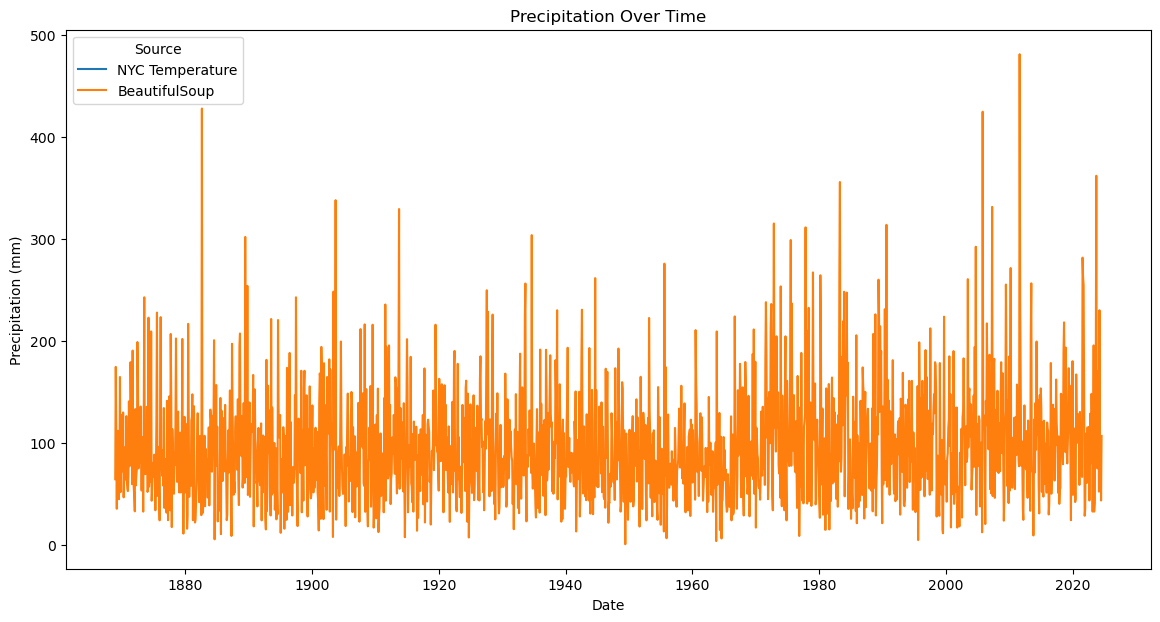

In [45]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=combined_data[combined_data['Source'].isin(['NYC Temperature', 'BeautifulSoup'])],
             x='date', y='precip', hue='Source')
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend(title='Source')
plt.show()



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


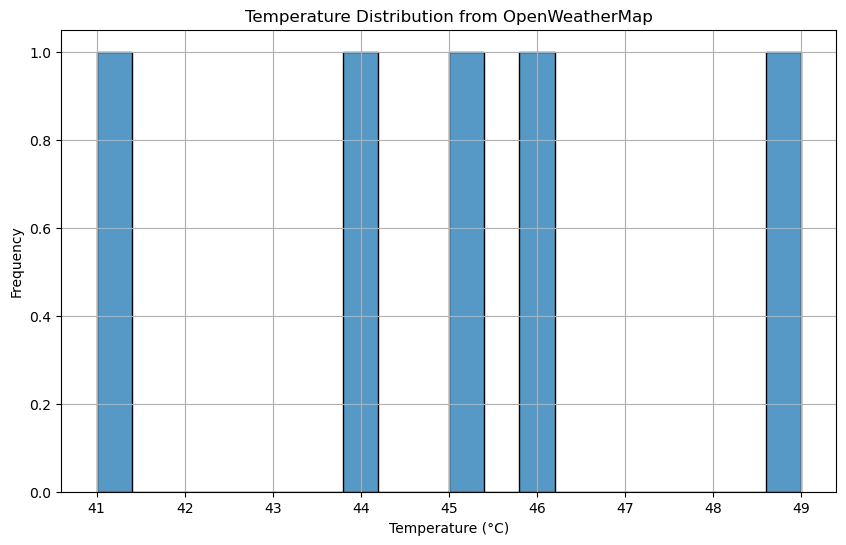

In [70]:
# Creating DataFrame
openweather_df = pd.DataFrame(openweather_data)

# Convert 'date' column to datetime, handling invalid entries
openweather_df['date'] = pd.to_datetime(openweather_df['date'], format='%d/%m/%y', errors='coerce')

# Drop rows with NaT in the 'date' column
openweather_df = openweather_df.dropna(subset=['date'])

# Plotting the distribution of 'tavg'
plt.figure(figsize=(10, 6))
sns.histplot(data=openweather_df, x='tavg', kde=False, bins=20)  # Remove KDE for clarity
plt.title('Temperature Distribution from OpenWeatherMap')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


        date  anomaly      Source
0 2024-08-01      0.5  TestSource
1 2024-08-02     -1.2  TestSource
2 2024-08-03      0.3  TestSource
3 2024-08-04     -0.8  TestSource
4 2024-08-05      0.0  TestSource
5 2024-08-06      1.5  TestSource
6 2024-08-07     -1.0  TestSource
7 2024-08-08      0.6  TestSource
8 2024-08-09     -0.4  TestSource
9 2024-08-10      1.1  TestSource


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


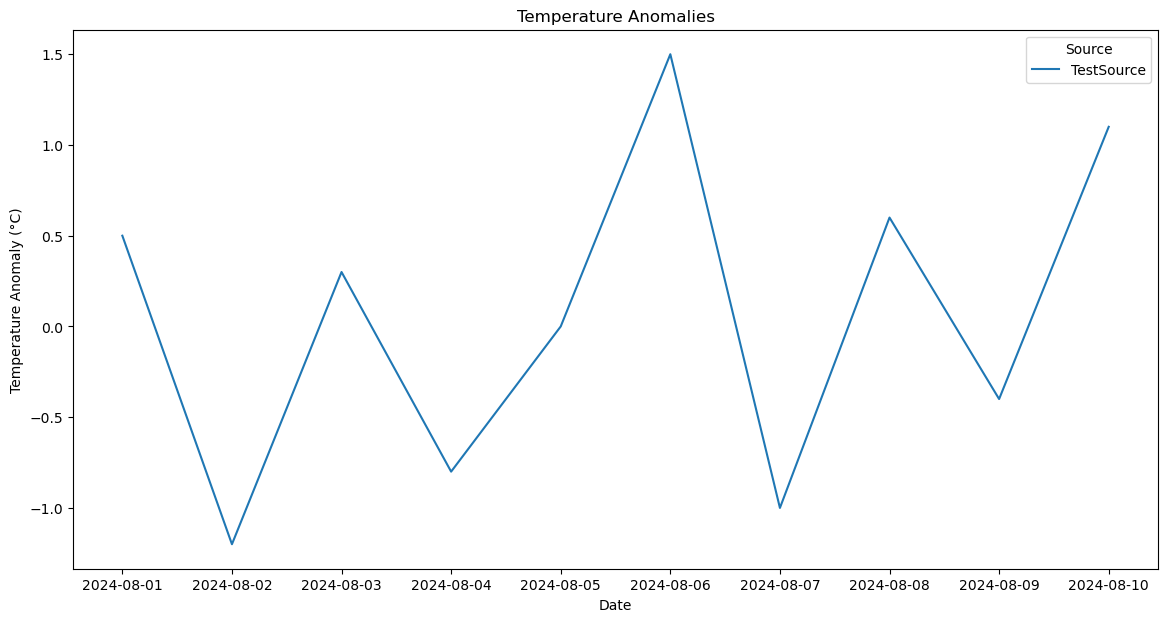

In [92]:
# Create a sample DataFrame with more data points for testing
test_data = {
    'date': pd.date_range(start='2024-08-01', periods=10, freq='D'),
    'anomaly': [0.5, -1.2, 0.3, -0.8, 0.0, 1.5, -1.0, 0.6, -0.4, 1.1],
    'Source': ['TestSource'] * 10
}
test_df = pd.DataFrame(test_data)

# Print sample data
print(test_df)

# Plot temperature anomalies with the test data
plt.figure(figsize=(14, 7))

# Plot
sns.lineplot(data=test_df, x='date', y='anomaly', hue='Source')
plt.title('Temperature Anomalies')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend(title='Source')
plt.show()



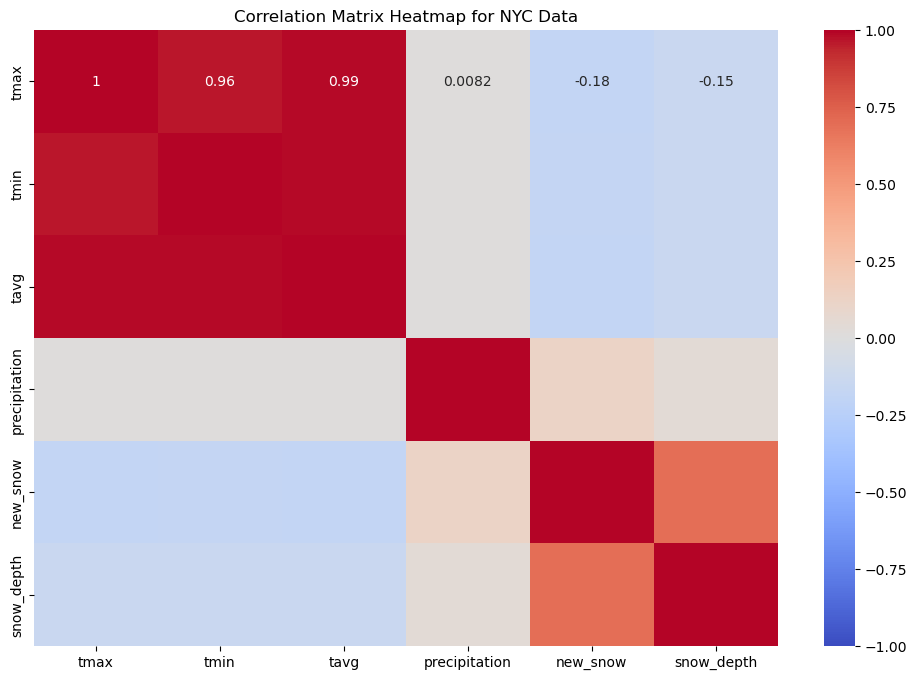

In [58]:
plt.figure(figsize=(12, 8))
corr_matrix = nyc_df[['tmax', 'tmin', 'tavg', 'precipitation', 'new_snow', 'snow_depth']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap for NYC Data')
plt.show()


Project Summary

In this project, I cleaned and transformed weather data from multiple sources, including the OpenWeatherMap API, a CSV file for New York City, and data parsed from a Wikimedia page using BeautifulSoup. The cleaning steps included flattening JSON data, replacing headers, converting temperature units from Kelvin to Celsius, handling missing values, and ensuring data types were consistent. Each dataset was then loaded into an SQLite database as individual tables.

After loading the data, I merged the datasets into a single dataset, adding a source identifier to distinguish between them. Using Matplotlib and Seaborn, I created visualizations to explore and compare the data, including temperature distributions, humidity levels, and the relationship between temperature and pressure across different sources.

Ethical Implications

During data wrangling, I made several changes, such as flattening JSON data, replacing headers, converting temperature units, and handling missing values. It was crucial to comply with the terms of service of the API provider and provide proper attribution to OpenWeatherMap. The transformations carried risks, such as potential misinterpretation of data due to unit changes and loss of context from removing certain columns. Assumptions included converting temperature data from Kelvin to Celsius and filling missing values with 'N/A'.

The data was sourced directly from credible providers, including OpenWeatherMap, and acquired ethically using API keys and adhering to terms of service. To mitigate ethical implications, I documented all transformations clearly, regularly reviewed and updated data handling practices to comply with guidelines and regulations, and ensured transparency in data processing to maintain trust and credibility.